In [1]:
import os 
import pandas as pd
import numpy as np
import librosa
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

In [2]:
DATASET_DIR = './Dataset/train/audio/'

# ALL DATA

In [3]:
# # This block of code was insipired by the following link:
# # https://github.com/OldBonhart/TensorFlow_Speech_Recognition_Challenge/blob/master/Train___EfficientNet.ipynb
# labels = os.listdir(DATASET_DIR)
# data_map = {}
# for ind, label in enumerate(labels):
#     data_path = DATASET_DIR + label
#     data_map[data_path] = label, os.listdir(data_path), ind
# data_map.keys()
# data_map = {}
# for ind, label in enumerate(labels):
#     data_path = DATASET_DIR + label
#     data_map[ind] = label, os.listdir(data_path), ind
    
# df = pd.DataFrame(data_map.values(), 
#                   columns=["label_name", "path", "label"])
# df = df.set_index(['label_name', 'label'])
# df.reset_index(inplace=True)
# rows = []
# _ = df.apply(lambda row: [rows.append([row['label_name'], row['label'], nn]) 
#                          for nn in row.path], axis=1)
# df_new = pd.DataFrame(rows, columns=df.columns)
# df_new.to_csv(r'speech_commands_dataset_all_labels.csv', index=True)
# #print(df_new["label_name"].value_counts())
# df_new
# train_df, val_df = train_test_split(df_new, stratify=df_new['label'], test_size=0.1)
# train_df, test_df = train_test_split(train_df, stratify=train_df['label'], test_size=0.1)
# print(train_df.shape, val_df.shape)
# print(train_df.dtypes)
# print(train_df.head())

# DATA WITHOUT BACKGROUND:

In [4]:
# This block of code was insipired by the following link:
# https://github.com/OldBonhart/TensorFlow_Speech_Recognition_Challenge/blob/master/Train___EfficientNet.ipynb
labels = os.listdir(DATASET_DIR)
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR + label
    data_map[data_path] = label, os.listdir(data_path), ind
data_map.keys()
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR + label
    data_map[ind] = label, os.listdir(data_path), ind

df = pd.DataFrame(data_map.values(),
                  columns=["label_name", "path", "label"])
df = df.set_index(['label_name', 'label'])
df.reset_index(inplace=True)
background_df = df[df['label_name'] == '_background_noise_']
df = df[df['label_name'] != '_background_noise_']
element_to_remove = "_background_noise_"
if element_to_remove in labels:
    labels.remove(element_to_remove)
rows = []
_ = df.apply(lambda row: [rows.append([row['label_name'], row['label'], nn])
                         for nn in row.path], axis=1)
df_new = pd.DataFrame(rows, columns=df.columns)
df_new.to_csv(r'speech_commands_dataset_all_labels.csv', index=True)
df_new['label']=df_new['label'].apply(lambda x: x if x<12 else x-1)
data = df_new
train_df, val_df = train_test_split(df_new, stratify=df_new['label'], test_size=0.1)
train_df, test_df = train_test_split(train_df, stratify=train_df['label'], test_size=0.2)
print(train_df.shape, val_df.shape)
print(train_df.dtypes)
print(train_df.head())

(46598, 3) (6473, 3)
label_name    object
label          int64
path          object
dtype: object
      label_name  label                   path
53076        yes     25  8a28231e_nohash_0.wav
12099         go      6  c0445658_nohash_3.wav
27793      three     12  d9ae8983_nohash_1.wav
35425       zero     17  7ea032f3_nohash_4.wav
50631        six     24  56f78b7e_nohash_0.wav


In [5]:
NUM_CLASSES = len(labels)

In [6]:
NUM_CLASSES

30

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

# Define your Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_heads, num_classes, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_size)
        self.transformer_layer = nn.TransformerEncoderLayer(
            hidden_size, num_heads, dim_feedforward=4*hidden_size,
            batch_first=True, dropout=dropout)  # Set batch_first to True
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Transpose to (seq_len, batch_size, input_size)
        x = self.transformer(x)
        x = torch.mean(x, dim=0)  # Average over sequence length
        x = self.fc(x)
        return x

# Parameters
input_size = 32000  # Assuming each waveform is of length 16000
hidden_size = 256  # Increased hidden size
num_layers = 8  # Increased number of layers
num_heads = 8  # Increased number of heads
dropout = 0.1  # Added dropout
batch_size = 32
# Instantiate the model
model = TransformerModel(input_size, hidden_size, num_layers, num_heads, num_classes=NUM_CLASSES, dropout=dropout)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def right_pad(waveform, minimal_length):
    length_signal = waveform.shape[0]
    if length_signal < minimal_length:
        missing_samples = minimal_length - length_signal
        last_dim_padding = (0, missing_samples)
        waveform = torch.nn.functional.pad(waveform, last_dim_padding)
    return waveform

class SpeechDataset(Dataset):
    def __init__(self, dataframe, num_classes, transform=None):
        self.data = dataframe
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label_name = self.data.iloc[idx, 0]  # Assuming label is in the first column
        label = self.data.iloc[idx, 1]  # Assuming label is in the second column
        path = self.data.iloc[idx, 2]    # Assuming path is in the third column
        signal_path = DATASET_DIR + label_name + '/' + path
        waveform, _ = librosa.load(signal_path, mono=True, sr=None)
        waveform = torch.tensor(waveform, dtype=torch.float32)
        waveform = right_pad(waveform, 32000)
        waveform = waveform.unsqueeze(0)
        label_tensor = F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()
        sample = {'waveform': waveform, 'label': label_tensor} 
        return sample

/Users/salveendutt/GithubRepos/Deep-Learning/.tfenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# num_classes = len(train_df["label"].unique())
train_dataset = SpeechDataset(dataframe=train_df, num_classes=NUM_CLASSES, transform=None)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SpeechDataset(dataframe=val_df, num_classes=NUM_CLASSES, transform=None)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SpeechDataset(dataframe=test_df, num_classes=NUM_CLASSES, transform=None)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
num_epochs = 3

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, targets = batch['waveform'], batch['label']
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # No need to compute gradients during validation
        for val_batch in val_loader:
            val_inputs, val_targets = val_batch['waveform'], val_batch['label']
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()  # Use .item() to get the scalar value of the loss
    
    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Validation - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_val_loss:.4f}')

Training - Epoch [1/3], Loss: 3.3827
Validation - Epoch [1/3], Loss: 3.3593
Training - Epoch [2/3], Loss: 3.3553
Validation - Epoch [2/3], Loss: 3.3479
Training - Epoch [3/3], Loss: 3.3535
Validation - Epoch [3/3], Loss: 3.3446


In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
import torch

model.eval()
all_targets = []
all_predicted = []

with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch['waveform'], batch['label']
        outputs = model(inputs)
        targets = torch.argmax(targets, dim=1) # Convert one-hot to index
        # print(outputs)
        outputs = F.softmax(outputs, dim=1)
        print(outputs)
        # Get the top two predictions and their indices
        top_two_values, top_two_indices = torch.topk(outputs, k=2, dim=1)

        # Second best predictions
        second_best_indices = top_two_indices[:, 1]    
        predicted = top_two_indices    
        # Append targets and predicted values to lists
        all_targets.extend(targets.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predicted)

tensor([[3.6601e-02, 3.9786e-02, 2.9575e-02, 2.3193e-02, 2.4117e-02, 2.7407e-02,
         3.1539e-02, 2.8125e-02, 3.7479e-02, 2.6258e-02, 3.3163e-02, 8.2941e-02,
         3.5935e-02, 6.0168e-06, 3.3439e-02, 3.9268e-02, 3.0645e-02, 3.7348e-02,
         3.9295e-02, 3.3223e-02, 2.9035e-02, 3.1786e-02, 2.3953e-02, 3.5187e-02,
         3.7516e-02, 3.1837e-02, 3.4165e-02, 3.4567e-02, 3.6111e-02, 3.6502e-02],
        [3.6601e-02, 3.9786e-02, 2.9575e-02, 2.3193e-02, 2.4117e-02, 2.7407e-02,
         3.1539e-02, 2.8125e-02, 3.7479e-02, 2.6258e-02, 3.3163e-02, 8.2941e-02,
         3.5935e-02, 6.0168e-06, 3.3439e-02, 3.9268e-02, 3.0645e-02, 3.7348e-02,
         3.9295e-02, 3.3223e-02, 2.9035e-02, 3.1786e-02, 2.3953e-02, 3.5187e-02,
         3.7516e-02, 3.1837e-02, 3.4165e-02, 3.4567e-02, 3.6111e-02, 3.6502e-02],
        [3.6601e-02, 3.9786e-02, 2.9575e-02, 2.3193e-02, 2.4117e-02, 2.7407e-02,
         3.1539e-02, 2.8125e-02, 3.7479e-02, 2.6258e-02, 3.3163e-02, 8.2941e-02,
         3.5935e-02, 6.016

KeyboardInterrupt: 

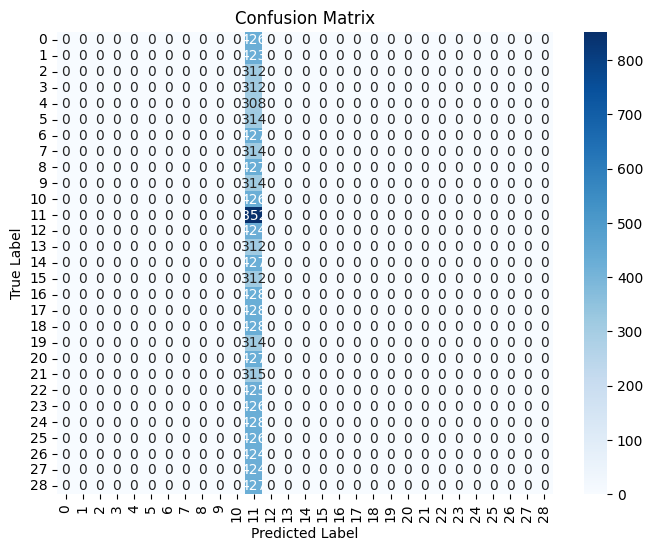

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [93]:
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch['waveform'], batch['label']
        outputs = model(inputs)
        print('targets.shape:', targets.shape)
        print('targets:', targets) 
        targets = torch.argmax(targets, dim=1)  # Convert one-hot to index
        print('targets:', targets) 
        print('outputs.shape:', outputs.shape)
        print('outputs:', outputs)
        
        # Apply softmax to get probabilities
        probabilities = torch.softmax(outputs, dim=1)
        print('probabilities:', probabilities)
        _, predicted = torch.max(probabilities, 1)
        
        print('predicted:', predicted)
        
        # Calculate accuracy
        # correct = (predicted == targets).sum().item()
        # total = targets.size(0)
        # accuracy = correct / total
        # print('Accuracy:', accuracy)
        
        # Append targets and predicted values to lists
        all_targets.extend(targets.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())
        break

targets.shape: torch.Size([1, 30])
targets: tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
targets: tensor([4])
outputs.shape: torch.Size([1, 30])
outputs: tensor([[ 9.9719e-02,  9.1554e-02, -2.5147e-01, -6.7440e-02, -3.8509e-01,
         -1.6679e-01,  1.6322e-01, -2.1717e-01,  1.2478e-01, -3.6925e-01,
         -1.1988e-01,  8.0535e-01,  6.2338e-02, -7.5417e+00, -9.1286e-02,
          1.4779e-01, -1.2626e-01,  6.2389e-02,  1.2684e-01,  5.8765e-03,
         -8.4423e-02,  1.4009e-01, -2.9548e-01,  1.3246e-02,  1.2700e-01,
          8.3482e-02,  1.6323e-01,  1.1978e-01,  7.0241e-02,  1.5894e-02]])
probabilities: tensor([[3.6783e-02, 3.6484e-02, 2.5890e-02, 3.1121e-02, 2.2652e-02, 2.8178e-02,
         3.9195e-02, 2.6793e-02, 3.7716e-02, 2.3013e-02, 2.9531e-02, 7.4491e-02,
         3.5433e-02, 1.7662e-05, 3.0388e-02, 3.8594e-02, 2.9343e-02, 3.5435e-02,
         3.7794e-02, 3.3488e-02, 3.0597e-02, 3.

In [91]:
NUM_CLASSES

30